In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core tavily-python wikipedia

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

# created startupmember and graph 

In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class StartupMember(BaseModel):
    affiliation: str = Field(
        description="Relevant background or company affiliation of the startup member.",
    )
    name: str = Field(
        description="Name of the startup founding or growth team member."
    )
    role: str = Field(
        description="Strategic role of the member in the startup (e.g., Founder, CTO, Head of Growth).",
    )
    description: str = Field(
        description="Brief narrative of their goals, strengths, and approach in scaling the startup.",
    )

    @property
    def persona(self) -> str:
        return (
            f"Name: {self.name}\n"
            f"Role: {self.role}\n"
            f"Affiliation: {self.affiliation}\n"
            f"Description: {self.description}\n"
        )

class StartupTeam(BaseModel):
    members: List[StartupMember] = Field(
        description="List of founding and growth team members involved in the startup."
    )

class GenerateStartupTeamState(TypedDict):
    topic: str  # Startup domain or product focus
    max_members: int  # Maximum number of startup team roles to generate
    founder_feedback: str  # Optional human feedback or steering notes
    members: List[StartupMember]  # The resulting team member personas


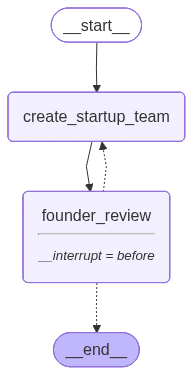

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

startup_team_instructions = """You are tasked with creating a set of startup founding and growth team personas. Follow these instructions carefully:

1. First, review the startup topic:
{topic}
        
2. Examine any founder feedback or context provided:
{founder_feedback}
    
3. Identify the key strategic needs required to build and scale the startup.
                    
4. Select the top {max_members} strategic roles needed.

5. Create one startup team member persona for each strategic role."""

def create_startup_team(state: GenerateStartupTeamState):
    """Create startup team members"""
    
    topic = state['topic']
    max_members = state['max_members']
    founder_feedback = state.get('founder_feedback', '')

    # Enforce structured output using StartupTeam model
    structured_llm = llm.with_structured_output(StartupTeam)

    # System prompt
    system_message = startup_team_instructions.format(
        topic=topic,
        founder_feedback=founder_feedback, 
        max_members=max_members
    )

    # Invoke LLM
    team = structured_llm.invoke([
        SystemMessage(content=system_message),
        HumanMessage(content="Generate the startup founding and growth team personas.")
    ])
    
    # Write the team list back into state
    return {"members": team.members}

def founder_review(state: GenerateStartupTeamState):
    """No-op node that may request interruption for human feedback"""
    pass

def should_continue(state: GenerateStartupTeamState):
    """Determine whether to continue generating based on feedback."""
    
    founder_feedback = state.get('founder_feedback', None)
    if founder_feedback:
        return "create_startup_team"
    
    return END

# Build graph
builder = StateGraph(GenerateStartupTeamState)
builder.add_node("create_startup_team", create_startup_team)
builder.add_node("founder_review", founder_review)

builder.add_edge(START, "create_startup_team")
builder.add_edge("create_startup_team", "founder_review")
builder.add_conditional_edges("founder_review", should_continue, ["create_startup_team", END])

# Compile with memory checkpoint
memory = MemorySaver()
graph = builder.compile(interrupt_before=['founder_review'], checkpointer=memory)

# Display visualization
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


# generated members

In [6]:
# Input
max_members = 4
topic = "AI-powered personal finance automation"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic": topic, "max_members": max_members}, thread, stream_mode="values"):
    members = event.get('members', '')
    if members:
        for member in members:
            print(f"Name: {member.name}")
            print(f"Affiliation: {member.affiliation}")
            print(f"Role: {member.role}")
            print(f"Description: {member.description}")
            print("-" * 50)


Name: Alex Johnson
Affiliation: Former Product Manager at a leading fintech company
Role: Founder & CEO
Description: Alex is passionate about leveraging AI to simplify personal finance. With a background in fintech product management, Alex aims to create a user-friendly platform that automates financial tasks, helping users save time and money. Alex's strengths lie in strategic vision and leadership, driving the team towards a scalable and impactful solution.
--------------------------------------------------
Name: Priya Patel
Affiliation: Ex-Lead Data Scientist at a top AI research lab
Role: CTO
Description: Priya is an expert in AI and machine learning, with a focus on developing algorithms that can predict and optimize financial decisions. Her goal is to build a robust AI engine that powers the startup's platform, ensuring accuracy and efficiency. Priya's approach is data-driven, and she excels in translating complex technical concepts into practical applications.
------------------

# Added feedback

In [7]:
# Update state with founder feedback (requesting a new role in the team)
graph.update_state(
    thread,
    {"founder_feedback": "Add a cybersecurity-focused CTO or Security Engineer to ensure secure system architecture."},
    as_node="founder_review"
)

# Re-run the graph stream until next interruption or completion
for event in graph.stream(None, thread, stream_mode="values"):
    members = event.get("members", "")
    if members:
        for member in members:
            print(member.persona)
            print("-" * 50)


Name: Alex Johnson
Role: Founder & CEO
Affiliation: Former Product Manager at a leading fintech company
Description: Alex is passionate about leveraging AI to simplify personal finance. With a background in fintech product management, Alex aims to create a user-friendly platform that automates financial tasks, helping users save time and money. Alex's strengths lie in strategic vision and leadership, driving the team towards a scalable and impactful solution.

--------------------------------------------------
Name: Priya Patel
Role: CTO
Affiliation: Ex-Lead Data Scientist at a top AI research lab
Description: Priya is an expert in AI and machine learning, with a focus on developing algorithms that can predict and optimize financial decisions. Her goal is to build a robust AI engine that powers the startup's platform, ensuring accuracy and efficiency. Priya's approach is data-driven, and she excels in translating complex technical concepts into practical applications.

----------------

# startup simstate subgraph 

In [8]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import get_buffer_string
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

tavily_search = TavilySearchResults(max_results=3)

class StartupSimState(MessagesState):
    max_num_turns: int  # Maximum number of strategic discussion rounds
    context: Annotated[list, operator.add]  # Conversation and data context aggregator
    team_member: StartupMember  # Current startup founder / executive persona being simulated
    simulation_log: str  # Narrative summary of decisions in the simulation
    strategy_notes: list  # Key business strategy insights, pivots, or risks encountered


/var/folders/7p/7t5ggdvs7cd4c2nqjhs3hz6h0000gn/T/ipykernel_33259/2541062040.py:8: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


# conducted interview and generated question

In [9]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

class InterviewState(MessagesState):
    max_num_turns: int  # Number of dialogue turns in the interview
    context: Annotated[list, operator.add]  # Collected background info, market insights, product notes
    team_member: StartupMember  # Startup founder/executive being interviewed
    interview: str  # Interview transcript
    sections: list  # Key summarized sections to surface in outer state

class MarketResearchQuery(BaseModel):
    search_query: str = Field(
        None, 
        description="Search query to gather market, competitor, or industry insights."
    )


In [10]:
question_instructions = """You are a startup team member conducting an interview to gather strategic insights 
that will help shape the product, market approach, or business strategy.

Your goal is to uncover insights that are:

1. Actionable: Information that directly influences product, market, or growth decisions.
2. Specific: Insights grounded in real examples, behaviors, or constraints.
3. Strategic: Insights that help the startup differentiate or scale effectively.

Here is your startup role and strategic focus: {goals}

Begin by introducing yourself in character (reflecting your startup role), then ask your first question.

Continue asking follow-up questions to probe deeper and refine understanding.

When you are satisfied with the insight, end the interview with:
"Thank you — this was incredibly helpful."

Stay in character the entire time, reflecting goals, tone, and motivations."""

def generate_question(state: InterviewState):
    """Node to generate a strategic interview question"""

    # Get state
    team_member = state["team_member"]
    messages = state["messages"]

    # System prompt based on the startup member's persona
    system_message = question_instructions.format(goals=team_member.persona)

    # Generate next question
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    # Append the new question to conversation state
    return {"messages": [question]}


# generate answer : Parallization

In [11]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

In [12]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [13]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

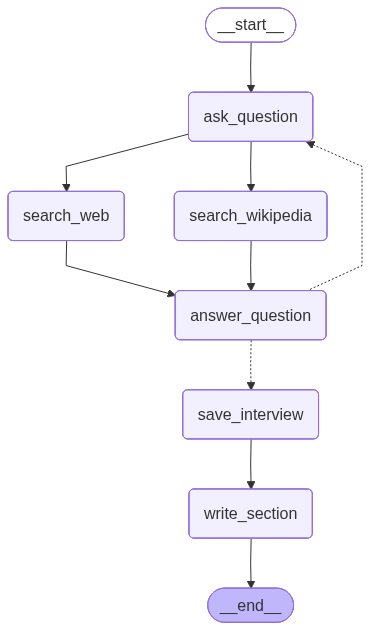

In [14]:
from langchain_core.messages import get_buffer_string
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

# Reuse the existing tavily_search helper
tavily_search = TavilySearchResults(max_results=3)

search_instructions = SystemMessage(
    content=(
        "You will be given a conversation between a startup team member and a subject-matter source. \n\n"
        "Your goal is to generate a concise, well-structured web/search query that will help retrieve "
        "market, competitor, technical, or product information directly relevant to the conversation. \n\n"
        "Steps:\n"
        "1. Read the full conversation provided.\n"
        "2. Pay special attention to the final question asked by the team member.\n"
        "3. Convert that final question into a precise search query suitable for web search or retrieval.\n\n"
        "Return only the search query in plain text (no explanation)."
    )
)

answer_instructions = """You are a subject-matter respondent answering questions from a startup team member.

Team member role and strategic focus: {goals}

Use only the provided context below to answer the question. Do not introduce external facts or assumptions beyond what is present in the context.

Context (sources are embedded in each document):
{context}

When you answer:
1. Base every claim on the context. If a claim is supported by a source, append a numeric citation (e.g., [1]) next to that sentence.
2. At the end, list the sources you used in order:
   [1] source-or-path, page or snippet info
   [2] etc.
3. Keep answers actionable and concise — highlight implications for product, go-to-market, or engineering where appropriate.

If you cannot find an answer in the context, say: "I can't answer that from the provided context." and do not invent details.
"""
section_writer_instructions = """You are a concise technical/business writer creating a short report section based on provided source documents.

Task:
1. Create a report in Markdown using the structure:
   ## <Title>
   ### Summary
   ### Sources

2. Title should be engaging and reflect the team member's focus: {focus}

3. Summary:
   - Give background/context relevant to the focus.
   - Highlight the most actionable, surprising, or strategic insights found in the sources.
   - Use a numbered list to reference the sources as you use them (e.g., [1], [2]).
   - Keep the section ~400 words maximum.

4. Sources:
   - List each source referenced, one per line, using the same ordering as the numeric citations.
   - Provide full link or document path where available.

Do not include interview transcripts or personal names. Output only the Markdown content for the section.
"""


def search_web(state: InterviewState):
    """ Retrieve documents from web search for a startup interview. """

    # Build structured query model
    structured_llm = llm.with_structured_output(MarketResearchQuery)
    # Generate search query from conversation
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    # Execute web search
    search_docs = tavily_search.invoke(search_query.search_query)

    # Format documents for downstream context
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def search_wikipedia(state: InterviewState):
    """ Retrieve documents from Wikipedia for the interview. """

    structured_llm = llm.with_structured_output(MarketResearchQuery)
    search_query = structured_llm.invoke([search_instructions] + state["messages"])

    # Load from Wikipedia
    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata.get("source","")}" page="{doc.metadata.get("page","")}" />\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}


def generate_answer(state: InterviewState):
    """ Node that formulates an answer using retrieved context. """

    # Replace analyst -> team_member
    team_member = state["team_member"]
    messages = state["messages"]
    context_items = state.get("context", [])

    # Combine context items into a single string for prompt substitution
    combined_context = "\n\n".join(context_items) if isinstance(context_items, list) else str(context_items)

    system_message = SystemMessage(content=answer_instructions.format(goals=team_member.persona, context=combined_context))

    # Invoke LLM to produce an answer
    answer = llm.invoke([system_message] + messages)

    # Mark the generated message as coming from the respondent
    answer.name = "subject_matter"

    # Append to the conversation
    return {"messages": [answer]}


def save_interview(state: InterviewState):
    """ Save interviews to a single string field for later summarization. """

    messages = state["messages"]
    interview_text = get_buffer_string(messages)
    return {"interview": interview_text}


def route_messages(state: InterviewState, name: str = "subject_matter"):
    """ Routing logic to decide whether to ask another question or finish. """

    messages = state["messages"]
    max_num_turns = state.get("max_num_turns", 2)

    # Count how many responses from the subject matter expert have occurred
    num_responses = len([m for m in messages if isinstance(m, AIMessage) and getattr(m, "name", None) == name])

    if num_responses >= max_num_turns:
        return "save_interview"

    # We assume messages end with a question -> answer pair, so check last question content
    # Protect against short messages list
    if len(messages) >= 2:
        last_question = messages[-2]
        # End phrase adapted to the startup interview ending
        if "Thank you — this was incredibly helpful" in last_question.content:
            return "save_interview"

    return "ask_question"


def write_section(state: InterviewState):
    """ Produce a short report section from the collected interview/context. """

    interview = state.get("interview", "")
    context_items = state.get("context", [])
    team_member = state["team_member"]

    # Prefer context for source documents; if not present, fall back to interview transcript
    source_for_writer = "\n\n".join(context_items) if context_items else interview

    system_message = SystemMessage(content=section_writer_instructions.format(focus=team_member.description))
    prompt = HumanMessage(content=f"Use this source to write your section: {source_for_writer}")

    section = llm.invoke([system_message, prompt])

    return {"sections": [section.content]}


interview_builder = StateGraph(InterviewState)

interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow: ask -> retrieval -> answer -> route -> save -> write -> end
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages, ["ask_question", "save_interview"])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Compile and visualize
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Startup Interviews")

# Optional: display graph visualization if in a notebook environment
display(Image(interview_graph.get_graph().draw_mermaid_png()))


In [19]:
members[0]

StartupMember(affiliation='Former Product Manager at a leading fintech startup', name='Alex Johnson', role='Founder & CEO', description="Alex is passionate about leveraging AI to simplify personal finance. With a background in fintech, Alex aims to create a user-friendly platform that automates financial tasks, helping users save time and money. Alex's strengths lie in strategic vision and product development, focusing on building a scalable business model that addresses real consumer pain points.")